## Imports

In [18]:
# builtin
from itertools import combinations

# sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import clone

# matplotlib
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pandas
import pandas as pd

## Load Digits DataSet

In [3]:
digits = load_digits()

## Preliminary data analysis
Looking into the digints dataset, it has 10 classes (labels) with approximately 180 samples per class, with a total of 1797 samples.

### classes
Each class represent a different digit. The classes are the digits 0-9.

### features
Each sample is a 8*8 image of a digit. Hence, each sample has 64 features, and each feature consists of an integer between 0 and 16 (including 0 and 16).

### shape of the data

In [4]:
print(digits.data.shape)

(1797, 64)


### Visualization of some of the digits

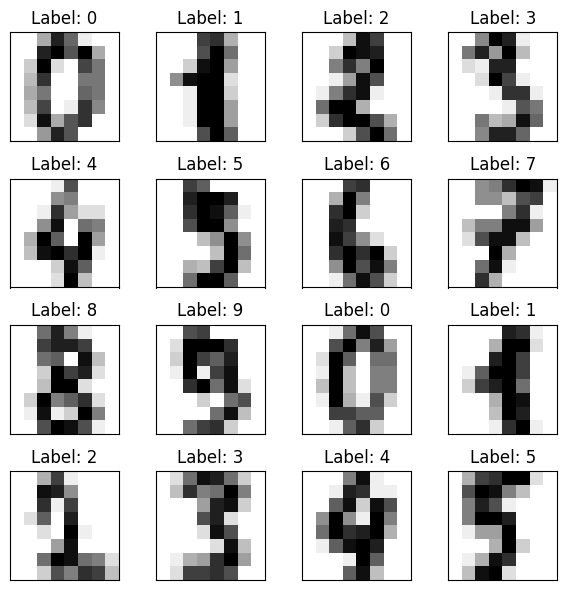

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(6, 6))
for ax, image, label in zip(axes.flat, digits.images, digits.target):
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: {}'.format(label))
    ax.set(xticks=[], yticks=[])
plt.tight_layout()
plt.show()

### Distirbution of target value

In [6]:
target = pd.DataFrame(digits.target, columns=['digit'])
print(target['digit'].value_counts())

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: digit, dtype: int64


### Some descriptive statistics for the features

In [7]:
features = pd.DataFrame(digits.data)
print(features.describe())

           0            1            2            3            4   \
count  1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.0     0.303840     5.204786    11.835838    11.848080   
std       0.0     0.907192     4.754826     4.248842     4.287388   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     1.000000    10.000000    10.000000   
50%       0.0     0.000000     4.000000    13.000000    13.000000   
75%       0.0     0.000000     9.000000    15.000000    15.000000   
max       0.0     8.000000    16.000000    16.000000    16.000000   

                5            6            7            8            9   ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000     0.000000     0.000000     0.000000     

## Learning using LogisticRegression
Now we are going to learn using the LogisticRegression model.
We are going to use a test-train ration of 0.1,0.2,...,0.9 to train a logistic regressor.
We will evaluate the accuracy of the model on the train set and then we will plot the accuracy of each ratio.

In [8]:
rs = np.arange(0.1,1,0.1)
X, y = digits.data, digits.target

First we will calculate the accuracys of each ratio size.

We've raised the max_iter to be 10000, as the logistic regressor fails to converge with the default value of 100, and also fails with 1000.

In [9]:
def run_logistic_regressor(rs: list[float], X: np.ndarray, y: np.ndarray) -> list[float]:
    accuracies = []
    for r in rs:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
        log_regressor = LogisticRegression(random_state=0, max_iter=10000)
        log_regressor.fit(X_train, y_train)
        acc = accuracy_score(y_test, log_regressor.predict(X_test))
        print(f"{r:.01f}: {acc:.04f}")
        accuracies.append(acc)
    return accuracies

Now lets plot our results !

In [10]:
def plot_accuracies(rs: list[float], accuracies: list[float]) -> None:
    plt.plot(rs, accuracies, marker='o')
    plt.grid(True)
    plt.xlabel("Train Size Ration")
    plt.ylabel("Accuracy on Test set")
    plt.title('Accuracy of Logistic Regression Model on Different Test Set Ratios')
    plt.show()

In [11]:
accuracies = run_logistic_regressor(rs, X, y)

0.1: 0.9722
0.2: 0.9722
0.3: 0.9519
0.4: 0.9624
0.5: 0.9588
0.6: 0.9555
0.7: 0.9499
0.8: 0.9492
0.9: 0.9370


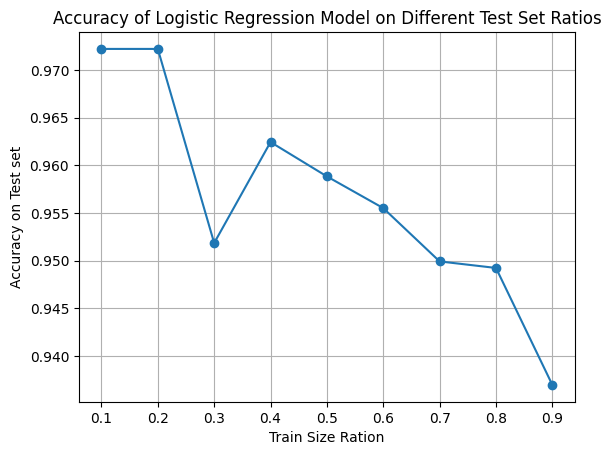

In [12]:
plot_accuracies(rs, accuracies)

## Unbalanced
Until now we've ran on a dataset which is balanced.

We are going to create a dataset of 1000 points which is unbalanced.

In [13]:
train_size = 1000
test_size = digits.data.shape[0] - 1000 

rand_indices = np.random.choice(digits.data.shape[0], 1000, replace=False)

unbalanced_data = digits.data[rand_indices]
unbalanced_target = digits.target[rand_indices]

## Label Balancing
We are going to take the unbalanced dataset and generate a new dataset with label balancing.

First, we will find lmin, the number corresponding to the label that appears the least in the data.

In [14]:
# Count the occurrences of each element in the array
counts = np.bincount(unbalanced_target)

# Find the minimum value of counts
l_min = np.min(counts)

# The number with the lowest appearance is the index with the smallest count
print(f"l_min is: {l_min}")

l_min is: 85


Now for each label in the dataset, we're going to select only l_min samples and add them to the new balanced dataset

In [15]:
balanced_data = None
balanced_target = None
for i in range(10):
    # get all indices where the label is i
    indices = np.where(unbalanced_target == i)[0] # it returns a tuple and we're interested in the first argument

    # choose l_min of them randomly
    l_min_indices = np.random.choice(indices, size=l_min, replace=False)
    
    # append to balanced target and data
    balanced_data = np.concatenate((balanced_data, unbalanced_data[l_min_indices])) if balanced_data is not None else unbalanced_data[l_min_indices]
    balanced_target = np.concatenate((balanced_target, unbalanced_target[l_min_indices])) if balanced_target is not None else unbalanced_target[l_min_indices]



Now, as instructed we're going to run the logistic regressor model again, but this time with the balanced data we've created.

Again, we're going to run train-test ration of 0.1,0.2,...,0.9. After that we'll plot again the ratio as function of the accuracy.

In [16]:
accuracies = run_logistic_regressor(rs, balanced_data, balanced_target)

0.1: 1.0000
0.2: 0.9412
0.3: 0.9492
0.4: 0.9529
0.5: 0.9576
0.6: 0.9490
0.7: 0.9378
0.8: 0.9221
0.9: 0.8261


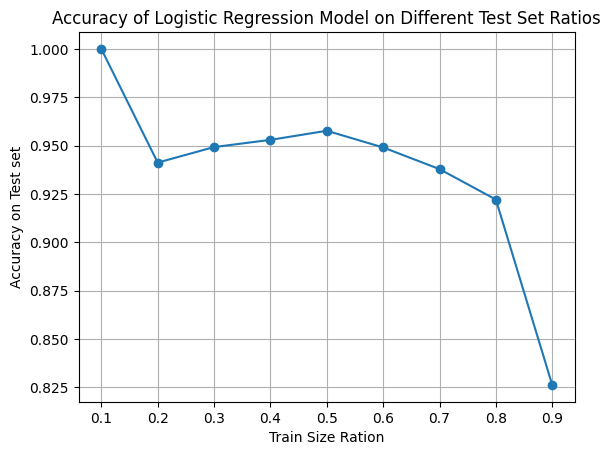

In [17]:
plot_accuracies(rs, accuracies)

### Naive k-features selection
We're going to run the LogisticRegression model, each time with k features from the data.

Then we're going to compare the k features that achieved the best results on the test set.

In [21]:
def naive_k_feature_selection(train: tuple, test: tuple, k: int):
    X_train, y_train = train
    X_test, y_test = test
    
    accuracies = {}
    
    # Get all combinations of k elements
    comb = list(combinations(range(X_train.shape[1]), k))
    log_regressor = LogisticRegression(random_state=0, max_iter=10000)
    for features in comb:
        curr_model = clone(log_regressor)
        curr_X_train = X_train[:, features]
        curr_X_test = X_test[:, features]
        curr_model.fit(curr_X_train, y_train)
        acc = accuracy_score(y_test, curr_model.predict(curr_X_test))
        accuracies[features] = acc
    
    best_features = max(accuracies, key=accuracies.get)
    return best_features, accuracies[best_features]
    

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)
k = 2
best_features, accuracy = naive_k_feature_selection((X_train, y_train), (X_test, y_test), k)
print(f"The 2 best features are {best_features} and they got accuracy of {accuracy:.04f}")
for feature in best_features:
    print(f"{digits.feature_names[feature]}")

After checking for the best 2 features to use, we got that they are features number (21, 61), which are pixel_2_5 and pixel_7_5, and they got accuracy of 0.45